# 1. Fundamentos Teóricos: NeSy e Lógica Tensorial (LTN)

## O que é Raciocínio Neuro-Simbólico (NeSy)?

O Raciocínio Neuro-Simbólico (NeSy) é uma área de pesquisa que busca combinar os pontos fortes da **Inteligência Artificial Simbólica** (raciocínio lógico, representação explícita de conhecimento) com os da **Aprendizagem Profunda (Deep Learning)** (percepção robusta, tolerância a ruído). O objetivo é criar sistemas que possam perceber o mundo de forma neural, mas raciocinar sobre ele de forma lógica e interpretável.

## Lógica Tensorial (LTN - Logic Tensor Networks)

LTN é uma arquitetura de NeSy que implementa a Lógica de Primeira Ordem (First-Order Logic - FOL) dentro de redes neurais, transformando o raciocínio lógico em um problema de otimização contínua.

* **Fundamentação:** LTN mapeia o conceito de "Verdade" para o intervalo contínuo $[0, 1]$, onde 1 é totalmente verdadeiro e 0 é totalmente falso.
* **Elementos Chave:**
    * **Termos:** Objetos (dados brutos, vetores) representados por tensores.
    * **Predicados:** Funções neurais (redes neurais) que recebem termos e retornam a satisfatibilidade (grau de verdade) de uma propriedade ou relação, entre 0 e 1.
    * **Operadores Lógicos:** Operadores como $\land$ (E), $\lor$ (OU), $\neg$ (NÃO), e $\Rightarrow$ (IMPLICA) são mapeados para funções contínuas e diferenciáveis (e.g., *t-norms* e *t-conorms*).
    * **Raciocínio:** O conhecimento (axiomas) é representado como a média da satisfatibilidade de todas as fórmulas. O treinamento otimiza os pesos da rede neural para maximizar essa satisfatibilidade média agregada ($\text{SatAgg}$), forçando a rede a aprender predicados que sejam consistentes com as regras lógicas dadas.

# 2. Dataset e Cenário: CLEVR Simplificado

O experimento utiliza um cenário sintético simplificado baseado na estrutura do dataset **CLEVR (Compositional Language and Elementary Visual Reasoning)**, um benchmark comum para raciocínio visual e linguístico.

## Estrutura do Objeto (Vetores de 11 Atributos)

Cada objeto na cena é representado por um vetor de entrada (Termo) de 11 dimensões, normalizado entre 0 e 1:

| Índice | Atributo | Normalização/Codificação | Notas |
| :---: | :--- | :--- | :--- |
| 0 | Posição X | Normalizado por $\text{Pos}_{\text{max}}=38.0$ | Usado para Predicados Relacionais (LeftOf, Below). |
| 1 | Posição Y | Normalizado por $\text{Pos}_{\text{max}}=27.0$ | |
| 2-4 | Cor (RGB) | One-hot ou Codificação Soft (e.g., Amarelo = [1, 1, 0]) | Usado para Predicados Unários (IsGreen). |
| 5-9 | Forma | One-hot para 5 formas (Círculo, Quadrado, Cilindro, Cone, Triângulo) | Usado para Predicados Unários (IsCylinder). |
| 10 | Tamanho | Valor Contínuo: 0.0 (Pequeno), 0.5 (Médio), 1.0 (Grande) | Usado para Predicados Unários (IsSmall). |

A simplificação permite que os Predicados (redes neurais) aprendam a relação entre o vetor de atributos e a satisfação lógica, sem a necessidade de uma CNN complexa de percepção inicial.


==================== INÍCIO DA EXECUÇÃO 1/5 ====================
Pré-Treinamento iniciado com 25 objetos fixos por 50 epochs...
Gerando plotagem do cenário Fixo de Pré-Treinamento (Requisito 1) e salvando em 'cenario_fixo.png'...
Plotagem salva com sucesso como 'cenario_fixo.png'.


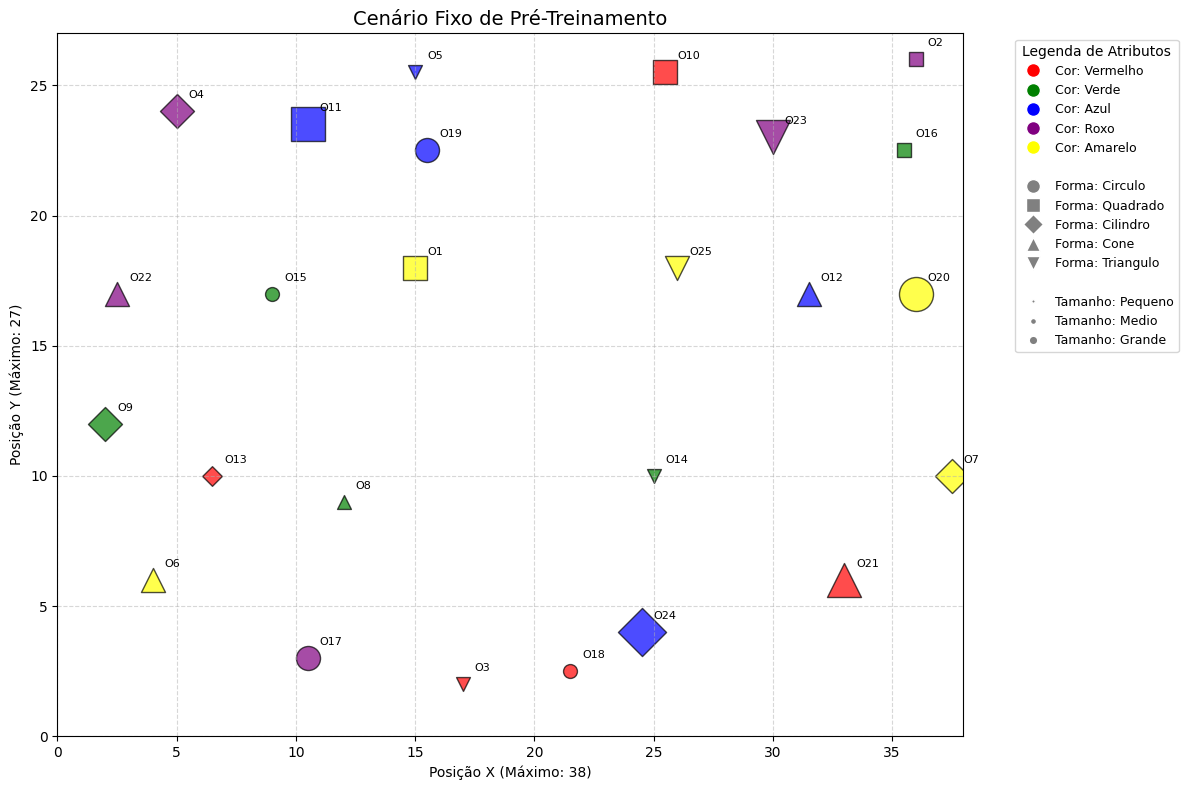

A imagem acima é o Requisito 1 (Cenário Fixo) e será exibida apenas na primeira execução para evitar poluir o output.
Pré-Treinamento Concluído (SatAgg Final Fixo: 0.7111)
Treinamento Principal iniciado com 25 objetos aleatórios por 150 epochs...
Treinamento Principal Concluído (SatAgg Final Aleatório: 0.8964)
GT Q1: 1, Pred Q1: 0.0041 | GT Q2: 1, Pred Q2: 0.0081

==================== INÍCIO DA EXECUÇÃO 2/5 ====================
Pré-Treinamento iniciado com 25 objetos fixos por 50 epochs...
Pré-Treinamento Concluído (SatAgg Final Fixo: 0.7162)
Treinamento Principal iniciado com 25 objetos aleatórios por 150 epochs...
Treinamento Principal Concluído (SatAgg Final Aleatório: 0.8946)
GT Q1: 1, Pred Q1: 0.0119 | GT Q2: 1, Pred Q2: 0.0049

==================== INÍCIO DA EXECUÇÃO 3/5 ====================
Pré-Treinamento iniciado com 25 objetos fixos por 50 epochs...
Pré-Treinamento Concluído (SatAgg Final Fixo: 0.7142)
Treinamento Principal iniciado com 25 objetos aleatórios por 150 epochs...

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sys
import matplotlib.pyplot as plt
import math
import textwrap
import platform
try:
    from IPython.display import Image, display
    IS_COLAB_OR_JUPYTER = True
except ImportError:
    IS_COLAB_OR_JUPYTER = False
try:
    if 'linux' in platform.platform().lower() and 'jupyter' not in sys.modules:
        plt.switch_backend('Agg')
except Exception:
    pass
# -------------------------------------------------------------------------------
# 0. CONFIGURAÇÃO E SETUP (Inalterada)
# -------------------------------------------------------------------------------
SEED = 42
N_RUNS = 5
NUM_OBJECTS = 25
POS_RANGE_X, POS_RANGE_Y = 38.0, 27.0
SAT_THRESHOLD = 0.7
EPOCHS_FIXED = 50
EPOCHS_RANDOM = 150
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VECTOR_DIM = 11
IDX_X, IDX_Y = 0, 1
IDX_R, IDX_G, IDX_B = 2, 3, 4
IDX_CIR, IDX_SQU, IDX_CYL, IDX_CON, IDX_TRI = 5, 6, 7, 8, 9
IDX_SIZE = 10

SHAPES = ['circle', 'square', 'cylinder', 'cone', 'triangle']
COLORS_BASIC = ['red', 'green', 'blue']
SIZES = [0.0, 0.5, 1.0]

MAP_ATTR_TO_IDX = {
    'red': IDX_R, 'green': IDX_G, 'blue': IDX_B,
    'circle': IDX_CIR, 'square': IDX_SQU, 'cylinder': IDX_CYL, 'cone': IDX_CON, 'triangle': IDX_TRI,
    'pequeno': 0.0, 'medio': 0.5, 'grande': 1.0
}
SHAPES_PT = ['circulo', 'quadrado', 'cilindro', 'cone', 'triangulo']
COLORS_PT = ['vermelho', 'verde', 'azul']

# -------------------------------------------------------------------------------
# 1. IMPLEMENTAÇÃO SIMPLIFICADA DO LTN (Inalterada)
# -------------------------------------------------------------------------------

class Predicate(nn.Module):
    instances = []

    def __init__(self, neural_network: nn.Module = None, lambda_function = None):
        super(Predicate, self).__init__()
        self.nn = neural_network
        self.lambda_fn = lambda_function
        Predicate.instances.append(self)

    @classmethod
    def lambda_op(cls, lambda_function):
        return cls(neural_network=None, lambda_function=lambda_function)

    def forward(self, *args):
        if self.lambda_fn:
            result = self.lambda_fn(*args)
            if result.dim() == 1:
                return result.unsqueeze(-1)
            if result.dim() > 1 and result.shape[-1] != 1:
                return result.unsqueeze(-1)
            return result

        if self.nn:
            inputs = torch.cat(args, dim=-1)
            return self.nn(inputs)

        raise ValueError("O predicado deve ter uma NN ou uma função lambda definida.")

    def parameters(self):
        return self.nn.parameters() if self.nn else []

# Operadores Lógicos e Quantificadores (Inalterados)
And = lambda *args: torch.min(torch.stack(args), dim=0)[0]
Not = lambda x: 1.0 - x
Or = lambda *args: torch.max(torch.stack(args), dim=0)[0]
Implies = lambda a, b: torch.max(Not(a), b)
Equiv = lambda a, b: And(Implies(a, b), Implies(b, a))
Forall = lambda formula: torch.mean(formula)
Exists = lambda formula: torch.max(formula)

# -------------------------------------------------------------------------------
# 2. FUNÇÕES DE GERAÇÃO DE DADOS, PLOTAGEM E MODELOS NN
# -------------------------------------------------------------------------------

def create_object_vector(obj_data):
    # (Cálculo do vetor inalterado)
    vector = torch.zeros(VECTOR_DIM, dtype=torch.float32)
    vector[IDX_X] = obj_data['pos'][0] / POS_RANGE_X
    vector[IDX_Y] = obj_data['pos'][1] / POS_RANGE_Y

    color_map = {'vermelho': IDX_R, 'verde': IDX_G, 'azul': IDX_B}
    # Note: O vetor de treinamento/random não inclui roxo/amarelo para manter o one-hot de 3 cores.
    if obj_data['cor'] in color_map: vector[color_map[obj_data['cor']]] = 1.0

    shape_map = {'circulo': IDX_CIR, 'quadrado': IDX_SQU, 'cilindro': IDX_CYL, 'cone': IDX_CON, 'triangulo': IDX_TRI}
    vector[shape_map[obj_data['forma']]] = 1.0

    vector[IDX_SIZE] = MAP_ATTR_TO_IDX[obj_data['size']]
    return vector

def generate_random_dataset(num_objects):
    # (Geração de dataset aleatório inalterada)
    objects = []
    for shape in SHAPES_PT:
        for _ in range(num_objects // len(SHAPES_PT)):
            obj_data = {
                'forma': shape, 'cor': random.choice(COLORS_PT),
                'pos': (random.uniform(1.0, POS_RANGE_X - 1.0), random.uniform(1.0, POS_RANGE_Y - 1.0)),
                'size': random.choice(['pequeno', 'medio', 'grande']),
            }
            objects.append(obj_data)
    random.shuffle(objects)
    all_vectors = [create_object_vector(obj) for obj in objects]
    dataset_tensor = torch.stack(all_vectors).to(DEVICE)
    data_df = pd.DataFrame(objects)
    return data_df, dataset_tensor

def create_fixed_dataset():
    # Dados que contêm 'amarelo' e 'roxo'
    fixed_data = [
        {'id': 'O1', 'forma': 'quadrado', 'cor_raw': 'amarelo', 'cor': [1.0, 1.0, 0.0], 'pos': (15.0, 18.0), 'size': 'medio'},
        {'id': 'O2', 'forma': 'quadrado', 'cor_raw': 'roxo', 'cor': [1.0, 0.0, 1.0], 'pos': (36.0, 26.0), 'size': 'pequeno'},
        {'id': 'O10', 'forma': 'quadrado', 'cor_raw': 'vermelho', 'cor': [1.0, 0.0, 0.0], 'pos': (25.5, 25.5), 'size': 'medio'},
        {'id': 'O11', 'forma': 'quadrado', 'cor_raw': 'azul', 'cor': [0.0, 0.0, 1.0], 'pos': (10.5, 23.5), 'size': 'grande'},
        {'id': 'O16', 'forma': 'quadrado', 'cor_raw': 'verde', 'cor': [0.0, 1.0, 0.0], 'pos': (35.5, 22.5), 'size': 'pequeno'},
        {'id': 'O19', 'forma': 'circulo', 'cor_raw': 'azul', 'cor': [0.0, 0.0, 1.0], 'pos': (15.5, 22.5), 'size': 'medio'},
        {'id': 'O20', 'forma': 'circulo', 'cor_raw': 'amarelo', 'cor': [1.0, 1.0, 0.0], 'pos': (36.0, 17.0), 'size': 'grande'},
        {'id': 'O15', 'forma': 'circulo', 'cor_raw': 'verde', 'cor': [0.0, 1.0, 0.0], 'pos': (9.0, 17.0), 'size': 'pequeno'},
        {'id': 'O17', 'forma': 'circulo', 'cor_raw': 'roxo', 'cor': [1.0, 0.0, 1.0], 'pos': (10.5, 3.0), 'size': 'medio'},
        {'id': 'O18', 'forma': 'circulo', 'cor_raw': 'vermelho', 'cor': [1.0, 0.0, 0.0], 'pos': (21.5, 2.5), 'size': 'pequeno'},
        {'id': 'O14', 'forma': 'triangulo', 'cor_raw': 'verde', 'cor': [0.0, 1.0, 0.0], 'pos': (25.0, 10.0), 'size': 'pequeno'},
        {'id': 'O25', 'forma': 'triangulo', 'cor_raw': 'amarelo', 'cor': [1.0, 1.0, 0.0], 'pos': (26.0, 18.0), 'size': 'medio'},
        {'id': 'O5', 'forma': 'triangulo', 'cor_raw': 'azul', 'cor': [0.0, 0.0, 1.0], 'pos': (15.0, 25.5), 'size': 'pequeno'},
        {'id': 'O3', 'forma': 'triangulo', 'cor_raw': 'vermelho', 'cor': [1.0, 0.0, 0.0], 'pos': (17.0, 2.0), 'size': 'pequeno'},
        {'id': 'O23', 'forma': 'triangulo', 'cor_raw': 'roxo', 'cor': [1.0, 0.0, 1.0], 'pos': (30.0, 23.0), 'size': 'grande'},
        {'id': 'O22', 'forma': 'cone', 'cor_raw': 'roxo', 'cor': [1.0, 0.0, 1.0], 'pos': (2.5, 17.0), 'size': 'medio'},
        {'id': 'O6', 'forma': 'cone', 'cor_raw': 'amarelo', 'cor': [1.0, 1.0, 0.0], 'pos': (4.0, 6.0), 'size': 'medio'},
        {'id': 'O21', 'forma': 'cone', 'cor_raw': 'vermelho', 'cor': [1.0, 0.0, 0.0], 'pos': (33.0, 6.0), 'size': 'grande'},
        {'id': 'O12', 'forma': 'cone', 'cor_raw': 'azul', 'cor': [0.0, 0.0, 1.0], 'pos': (31.5, 17.0), 'size': 'medio'},
        {'id': 'O8', 'forma': 'cone', 'cor_raw': 'verde', 'cor': [0.0, 1.0, 0.0], 'pos': (12.0, 9.0), 'size': 'pequeno'},
        {'id': 'O24', 'forma': 'cilindro', 'cor_raw': 'azul', 'cor': [0.0, 0.0, 1.0], 'pos': (24.5, 4.0), 'size': 'grande'},
        {'id': 'O7', 'forma': 'cilindro', 'cor_raw': 'amarelo', 'cor': [1.0, 1.0, 0.0], 'pos': (37.5, 10.0), 'size': 'medio'},
        {'id': 'O13', 'forma': 'cilindro', 'cor_raw': 'vermelho', 'cor': [1.0, 0.0, 0.0], 'pos': (6.5, 10.0), 'size': 'pequeno'},
        {'id': 'O4', 'forma': 'cilindro', 'cor_raw': 'roxo', 'cor': [1.0, 0.0, 1.0], 'pos': (5.0, 24.0), 'size': 'medio'},
        {'id': 'O9', 'forma': 'cilindro', 'cor_raw': 'verde', 'cor': [0.0, 1.0, 0.0], 'pos': (2.0, 12.0), 'size': 'medio'},
    ]

    def create_vector_fixed(obj_data):
        # (Criação de vetor para treinamento inalterada)
        vector = torch.zeros(VECTOR_DIM, dtype=torch.float32)
        vector[IDX_X] = obj_data['pos'][0] / POS_RANGE_X
        vector[IDX_Y] = obj_data['pos'][1] / POS_RANGE_Y
        vector[IDX_R:IDX_B + 1] = torch.tensor(obj_data['cor'])
        shape_map = {'circulo': IDX_CIR, 'quadrado': IDX_SQU, 'cilindro': IDX_CYL, 'cone': IDX_CON, 'triangulo': IDX_TRI}
        vector[shape_map[obj_data['forma']]] = 1.0
        vector[IDX_SIZE] = MAP_ATTR_TO_IDX[obj_data['size']]
        return vector

    all_vectors = [create_vector_fixed(obj) for obj in fixed_data]
    dataset_tensor = torch.stack(all_vectors).to(DEVICE)
    data_df = pd.DataFrame(fixed_data)

    # 🚨 CORREÇÃO CRÍTICA: Mantém as cores 'roxo' e 'amarelo' na coluna 'cor' do DataFrame para PLOTAGEM.
    data_df['cor'] = data_df['cor_raw']

    data_df['forma'] = data_df['forma']

    return data_df, dataset_tensor

def plot_scenario(data_df, title="Cenário Aleatório CLEVR-like", filename=None):
    # (Resto da função de plotagem inalterada)
    plt.figure(figsize=(12, 8))
    # Note que 'roxo' e 'amarelo' estão DEFINIDOS aqui:
    color_map_plot = {'vermelho': 'red', 'verde': 'green', 'azul': 'blue','roxo': 'purple', 'amarelo': 'yellow' }
    size_map = {'pequeno': 100, 'medio': 300, 'grande': 600}
    shape_map = {'circulo': 'o', 'quadrado': 's', 'cilindro': 'D', 'cone': '^', 'triangulo': 'v'}

    for index, row in data_df.iterrows():
        x, y = row['pos']
        # Usa a cor do DataFrame (agora corrigida)
        color = color_map_plot.get(row['cor'], 'black')
        size = size_map.get(row['size'], 200)
        marker = shape_map.get(row['forma'], 'x')
        plt.scatter(x, y, s=size, c=color, marker=marker, alpha=0.7, edgecolors='black', linewidth=1)
        obj_label = row.get('id', str(index+1))
        plt.text(x + 0.5, y + 0.5, obj_label, fontsize=8)

    plt.xlim(0, POS_RANGE_X)
    plt.ylim(0, POS_RANGE_Y)
    plt.title(title, fontsize=14)
    plt.xlabel("Posição X (Máximo: 38)"); plt.ylabel("Posição Y (Máximo: 27)")
    plt.grid(True, linestyle='--', alpha=0.5)

    legend_handles = []
    for name, color_code in color_map_plot.items():
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_code, markersize=10, label=f'Cor: {name.capitalize()}'))
    legend_handles.append(plt.Line2D([0], [0], linestyle='none', label=''))
    for name, marker_code in shape_map.items():
        legend_handles.append(plt.Line2D([0], [0], marker=marker_code, color='w', markerfacecolor='gray', markersize=10, label=f'Forma: {name.capitalize()}'))
    legend_handles.append(plt.Line2D([0], [0], linestyle='none', label=''))
    for name, size_val in size_map.items():
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=np.sqrt(size_val)/4, label=f'Tamanho: {name.capitalize()}'))

    plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.05, 1), title="Legenda de Atributos", fontsize=9)
    plt.tight_layout(rect=[0, 0, 1.0, 1])

    if filename:
        try:
            plt.savefig(filename, bbox_inches='tight')
            plt.close()
            print(f"Plotagem salva com sucesso como '{filename}'.")
        except Exception as e:
            print(f"Aviso: Não foi possível salvar o arquivo '{filename}'. Tentando exibir. Erro: {e}")
            plt.show()
    else:
        plt.show()

# Funções de Ground Truth Hard (Inalteradas)
def hard_Below(pos1, pos2): return 1 if pos1[1] < pos2[1] else 0
def hard_LeftOf(pos1, pos2): return 1 if pos1[0] < pos2[0] else 0
def hard_InBetween(pos_x, pos_y, pos_z):
    x_x = pos_x[0]
    y_x, z_x = pos_y[0], pos_z[0]
    between_x = (min(y_x, z_x) < x_x < max(y_x, z_x))
    return 1 if between_x else 0

def calculate_ground_truth(data_df):
    is_small_gt = data_df['size'] == 'pequeno'
    is_cylinder_gt = data_df['forma'] == 'cilindro'
    is_square_gt = data_df['forma'] == 'quadrado'
    is_cone_gt = data_df['forma'] == 'cone'
    is_green_gt = data_df['cor'] == 'verde'

    gt_Q1 = 0
    for i in range(len(data_df)):
        x_data = data_df.iloc[i]
        # Aqui, usamos a coluna 'size' que é consistente com o vetor de entrada
        if not is_small_gt.iloc[i]: continue
        found_y = False
        for j in range(len(data_df)):
            y_data = data_df.iloc[j]
            if is_cylinder_gt.iloc[j] and hard_Below(x_data['pos'], y_data['pos']):
                found_y = True; break
        if not found_y: continue
        found_z = False
        for k in range(len(data_df)):
            z_data = data_df.iloc[k]
            if is_square_gt.iloc[k] and hard_LeftOf(x_data['pos'], z_data['pos']):
                found_z = True; break
        if found_y and found_z: gt_Q1 = 1; break

    gt_Q2 = 0
    for i in range(len(data_df)):
        x_data = data_df.iloc[i]
        if is_cone_gt.iloc[i] and is_green_gt.iloc[i]:
            for j in range(len(data_df)):
                if i == j: continue
                y_data = data_df.iloc[j]
                for k in range(len(data_df)):
                    if k == i or k == j: continue
                    z_data = data_df.iloc[k]
                    if hard_InBetween(x_data['pos'], y_data['pos'], z_data['pos']): gt_Q2 = 1; break
                if gt_Q2 == 1: break
        if gt_Q2 == 1: break

    return gt_Q1, gt_Q2


# Definições de NNs (Inalteradas)
class AttributeNN(nn.Module):
    def __init__(self):
        super(AttributeNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(VECTOR_DIM, 32), nn.LeakyReLU(0.1),
            nn.Linear(32, 16), nn.LeakyReLU(0.1),
            nn.Linear(16, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)

class RelationNN(nn.Module):
    def __init__(self, num_inputs=2):
        super(RelationNN, self).__init__()
        input_dim = num_inputs * VECTOR_DIM
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64), nn.LeakyReLU(0.1),
            nn.Linear(64, 32), nn.LeakyReLU(0.1),
            nn.Linear(32, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)

# Setup de Predicados (Inalterado)
def setup_predicates():
    Predicate.instances = []
    P = {}
    slope = 30.0

    for name in COLORS_BASIC + SHAPES:
        P[f'Is{name.capitalize()}'] = Predicate(AttributeNN()).to(DEVICE)
    P['IsSmall'] = Predicate(AttributeNN()).to(DEVICE)
    P['IsMedium'] = Predicate(AttributeNN()).to(DEVICE)
    P['IsBig'] = Predicate(AttributeNN()).to(DEVICE)

    P['SameShape'] = Predicate(RelationNN(num_inputs=2)).to(DEVICE)
    P['SameColor'] = Predicate(RelationNN(num_inputs=2)).to(DEVICE)

    P['LeftOf'] = Predicate.lambda_op(
        lambda x, y: torch.sigmoid(slope * (y[..., IDX_X] - x[..., IDX_X]))
    )
    P['RightOf'] = Predicate.lambda_op(
        lambda x, y: torch.sigmoid(slope * (x[..., IDX_X] - y[..., IDX_X]))
    )
    P['Below'] = Predicate.lambda_op(
        lambda x, y: torch.sigmoid(slope * (y[..., IDX_Y] - x[..., IDX_Y]))
    )
    P['Above'] = Predicate.lambda_op(
        lambda x, y: torch.sigmoid(slope * (x[..., IDX_Y] - y[..., IDX_Y]))
    )

    P['CloseTo'] = Predicate.lambda_op(
        lambda x, y: torch.exp(-2.0 * torch.sum((x[..., IDX_X:IDX_Y+1] - y[..., IDX_X:IDX_Y+1])**2, dim=-1))
    )

    size_epsilon = 0.01
    P['SameSize'] = Predicate.lambda_op(
        lambda x, y: 1.0 - torch.abs(x[..., IDX_SIZE] - y[..., IDX_SIZE]) / size_epsilon
    )

    LeftOf = P['LeftOf']
    RightOf = P['RightOf']

    P['InBetween'] = Predicate.lambda_op(
        lambda x, y, z: Or(
            And(LeftOf(y, x), RightOf(z, x)),
            And(LeftOf(z, x), RightOf(y, x))
        )
    )

    return P

# Funções Auxiliares de Grounding (Inalteradas)
def get_attribute_grounding(obj_vector, idx):
    return obj_vector[..., idx].unsqueeze(-1)

def size_similarity(obj_vector, target_value, sigma=0.05):
    size_val = obj_vector[..., IDX_SIZE].unsqueeze(-1)
    return torch.exp(-torch.pow(size_val - target_value, 2) / (2 * sigma**2))

# Cálculo dos Axiomas (Inalterado)
def compute_axioms(objects_tensor, P):
    axioms_values = []
    n_objects = objects_tensor.shape[0]

    # --- 3.1 Axiomas de Grounding & Taxonomia ---
    for name in COLORS_BASIC:
        idx = MAP_ATTR_TO_IDX[name]
        predicate = P[f'Is{name.capitalize()}']
        axiom = Equiv(predicate(objects_tensor), get_attribute_grounding(objects_tensor, idx))
        axioms_values.append(Forall(axiom))

    for name in SHAPES:
        idx = MAP_ATTR_TO_IDX[name]
        predicate = P[f'Is{name.capitalize()}']
        axiom = Equiv(predicate(objects_tensor), get_attribute_grounding(objects_tensor, idx))
        axioms_values.append(Forall(axiom))

    axioms_values.append(Forall(Equiv(P['IsSmall'](objects_tensor), size_similarity(objects_tensor, 0.0))))
    axioms_values.append(Forall(Equiv(P['IsMedium'](objects_tensor), size_similarity(objects_tensor, 0.5))))
    axioms_values.append(Forall(Equiv(P['IsBig'](objects_tensor), size_similarity(objects_tensor, 1.0))))

    all_shapes_pred = torch.stack([P[f'Is{s.capitalize()}'](objects_tensor) for s in SHAPES])

    for i in range(len(SHAPES)):
        for j in range(i + 1, len(SHAPES)):
            excl_formula = Not(And(all_shapes_pred[i], all_shapes_pred[j]))
            axioms_values.append(Forall(excl_formula))

    coverage_formula = Or(*[P[f'Is{s.capitalize()}'](objects_tensor) for s in SHAPES])
    axioms_values.append(Forall(coverage_formula))

    # --- 3.3 Axiomas de Raciocínio (Geométrico) ---
    x_all = objects_tensor.unsqueeze(1).repeat(1, n_objects, 1).view(-1, VECTOR_DIM)
    y_all = objects_tensor.unsqueeze(0).repeat(n_objects, 1, 1).view(-1, VECTOR_DIM)
    x_all3 = objects_tensor.unsqueeze(1).unsqueeze(2).repeat(1, n_objects, n_objects, 1).view(-1, VECTOR_DIM)
    y_all3 = objects_tensor.unsqueeze(0).unsqueeze(2).repeat(n_objects, 1, n_objects, 1).view(-1, VECTOR_DIM)
    z_all3 = objects_tensor.unsqueeze(0).unsqueeze(1).repeat(n_objects, n_objects, 1, 1).view(-1, VECTOR_DIM)

    # Raciocínio Horizontal
    not_left_of_self = Not(P['LeftOf'](objects_tensor, objects_tensor))
    axioms_values.append(Forall(not_left_of_self))
    asymmetry_formula = Implies(P['LeftOf'](x_all, y_all), Not(P['LeftOf'](y_all, x_all)))
    axioms_values.append(Forall(asymmetry_formula))
    inverse_h_formula = Equiv(P['LeftOf'](x_all, y_all), P['RightOf'](y_all, x_all))
    axioms_values.append(Forall(inverse_h_formula))
    antecedent_trans = And(P['LeftOf'](x_all3, y_all3), P['LeftOf'](y_all3, z_all3))
    transitivity_formula = Implies(antecedent_trans, P['LeftOf'](x_all3, z_all3))
    axioms_values.append(Forall(transitivity_formula))

    # Restrição Quadrado-Círculo
    antecedent_sc = And(P['IsSquare'](x_all), P['IsCircle'](y_all))
    sc_formula = Implies(antecedent_sc, P['RightOf'](x_all, y_all))
    axioms_values.append(Forall(sc_formula))

    # Restrição de Proximidade (Q3 - Requisito)
    antecedent_q3 = And(P['IsTriangle'](x_all), P['IsTriangle'](y_all), P['CloseTo'](x_all, y_all))
    q3_formula = Implies(antecedent_q3, P['SameSize'](x_all, y_all))
    axioms_values.append(Forall(q3_formula))

    # Raciocínio Vertical
    inverse_v_formula = Equiv(P['Below'](x_all, y_all), P['Above'](y_all, x_all))
    axioms_values.append(Forall(inverse_v_formula))
    antecedent_trans_v = And(P['Below'](x_all3, y_all3), P['Below'](y_all3, z_all3))
    transitivity_formula_v = Implies(antecedent_trans_v, P['Below'](x_all3, z_all3))
    axioms_values.append(Forall(transitivity_formula_v))

    # canStack
    y_is_bad_base = Or(P['IsCone'](y_all), P['IsTriangle'](y_all))
    stability_condition = P['SameSize'](x_all, y_all)
    full_stability_req = And(Not(y_is_bad_base), stability_condition)
    canstack_formula = Implies(P['Below'](x_all, y_all), full_stability_req)
    axioms_values.append(Forall(canstack_formula))

    # F3: Posição Relativa
    f3_formula = Implies(P['Below'](x_all, y_all), Not(P['LeftOf'](x_all, y_all)))
    axioms_values.append(Forall(f3_formula))

    clean_axioms = []
    for val in axioms_values:
        val = val.mean().unsqueeze(0)
        if torch.all(torch.isfinite(val)):
            clean_axioms.append(val)
        else:
            clean_axioms.append(torch.tensor([0.5]).to(DEVICE))

    return clean_axioms

# Cálculo das Fórmulas (Inalterado)
def calculate_formulas_sataag(objects_tensor, P):
    n_objects = objects_tensor.shape[0]
    x_all = objects_tensor.unsqueeze(1).repeat(1, n_objects, 1).view(-1, VECTOR_DIM)
    y_all = objects_tensor.unsqueeze(0).repeat(n_objects, 1, 1).view(-1, VECTOR_DIM)

    # Q1: Filtragem Composta
    R_xy = And(P['IsCylinder'](y_all), P['Below'](x_all, y_all))
    Qy_x = torch.max(R_xy.view(n_objects, n_objects), dim=1)[0].unsqueeze(1)
    S_xz = And(P['IsSquare'](y_all), P['LeftOf'](x_all, y_all))
    Qz_x = torch.max(S_xz.view(n_objects, n_objects), dim=1)[0].unsqueeze(1)
    combined_x_Q1 = And(P['IsSmall'](objects_tensor), Qy_x, Qz_x)
    sat_Q1 = Exists(combined_x_Q1).item()

    # Q2: Dedução de Posição Absoluta
    x_all3 = objects_tensor.unsqueeze(1).unsqueeze(2).repeat(1, n_objects, n_objects, 1).view(-1, VECTOR_DIM)
    y_all3 = objects_tensor.unsqueeze(0).unsqueeze(2).repeat(n_objects, 1, n_objects, 1).view(-1, VECTOR_DIM)
    z_all3 = objects_tensor.unsqueeze(0).unsqueeze(1).repeat(n_objects, n_objects, 1, 1).view(-1, VECTOR_DIM)

    P_xyz_Q2 = And(P['IsCone'](x_all3), P['IsGreen'](x_all3), P['InBetween'](x_all3, y_all3, z_all3))
    sat_Q2 = Exists(P_xyz_Q2).item()

    # Fórmulas Universais (Para Tabela 2)
    sat_F1 = Forall(Equiv(P['CloseTo'](x_all, y_all), P['CloseTo'](y_all, x_all))).item()
    sat_F3 = Forall(Implies(P['Below'](x_all, y_all), Not(P['LeftOf'](x_all, y_all)))).item()
    sat_F6 = Forall(Implies(P['SameShape'](x_all, y_all), P['SameSize'](x_all, y_all))).item()
    antecedent_q3 = And(P['IsTriangle'](x_all), P['IsTriangle'](y_all), P['CloseTo'](x_all, y_all))
    sat_Q3 = Forall(Implies(antecedent_q3, P['SameSize'](x_all, y_all))).item()

    # Queries de Quantificadores (lastOnTheLeft/Right e Existencial)
    left_of_all_y = P['LeftOf'](x_all, y_all).view(n_objects, n_objects)
    sat_for_all_y = Forall(left_of_all_y)
    sat_last_left = Exists(sat_for_all_y).item()

    right_of_all_y = P['RightOf'](x_all, y_all).view(n_objects, n_objects)
    sat_for_all_y_right = Forall(right_of_all_y)
    sat_last_right = Exists(sat_for_all_y_right).item()

    is_square_y = P['IsSquare'](y_all)
    left_of_x_y = P['LeftOf'](x_all, y_all)
    implication = Implies(is_square_y, left_of_x_y)
    forall_y_implication = Forall(implication.view(n_objects, n_objects))
    sat_consulta_existencial = Exists(forall_y_implication).item()


    return {
        'F1': sat_F1, 'F3': sat_F3, 'F6': sat_F6,
        'Q3_Axioma': sat_Q3,
        'Q1': sat_Q1, 'Q2': sat_Q2,
        'lastOnTheLeft': sat_last_left,
        'lastOnTheRight': sat_last_right,
        'ConsultaExistencial': sat_consulta_existencial
    }

# Cálculo de Métricas (Inalterado)
def calculate_metrics(gt_values, ltn_predictions):
    binarized_predictions = [1 if sat > SAT_THRESHOLD else 0 for sat in ltn_predictions]

    return {
        'Acurácia': accuracy_score(gt_values, binarized_predictions),
        'Precisão': precision_score(gt_values, binarized_predictions, zero_division=0),
        'Recall': recall_score(gt_values, binarized_predictions, zero_division=0),
        'F1 Score': f1_score(gt_values, binarized_predictions, zero_division=0)
    }

# Função de Execução do Experimento (Inalterada)
def run_experiment(run_id, epochs_fixed=EPOCHS_FIXED, epochs_random=EPOCHS_RANDOM, lr=LEARNING_RATE):
    print(f"\n{'='*20} INÍCIO DA EXECUÇÃO {run_id+1}/{N_RUNS} {'='*20}")

    P = setup_predicates()
    all_params = []
    for pred in Predicate.instances:
        if pred.nn: all_params.extend(pred.parameters())

    if not all_params:
        print("Aviso: Nenhum parâmetro treinável encontrado. Verifique a definição dos predicados.")
        return None

    optimizer = torch.optim.Adam(all_params, lr=lr)

    # --- FASE 1: PRÉ-TREINAMENTO (DATASET FIXO) ---
    fixed_df, fixed_tensor = create_fixed_dataset()
    print(f"Pré-Treinamento iniciado com {fixed_tensor.shape[0]} objetos fixos por {epochs_fixed} epochs...")

    if run_id == 0:
        filename = "cenario_fixo.png"
        print(f"Gerando plotagem do cenário Fixo de Pré-Treinamento (Requisito 1) e salvando em '{filename}'...")
        plot_scenario(fixed_df, title="Cenário Fixo de Pré-Treinamento", filename=filename)

        if IS_COLAB_OR_JUPYTER:
            try:
                display(Image(filename=filename))
                print("A imagem acima é o Requisito 1 (Cenário Fixo) e será exibida apenas na primeira execução para evitar poluir o output.")
            except Exception as e:
                print(f"Aviso: Não foi possível exibir a imagem salva no Notebook. Erro: {e}")

    for epoch in range(epochs_fixed):
        optimizer.zero_grad()
        all_axioms_sat = compute_axioms(fixed_tensor, P)
        loss = 1.0 - torch.mean(torch.stack(all_axioms_sat))
        loss.backward()
        optimizer.step()

    final_sat_fixed = 1.0 - loss.item()
    print(f"Pré-Treinamento Concluído (SatAgg Final Fixo: {final_sat_fixed:.4f})")

    # --- FASE 2: TREINAMENTO PRINCIPAL (DATASET ALEATÓRIO) ---
    data_df, dataset_tensor = generate_random_dataset(NUM_OBJECTS)
    gt_Q1, gt_Q2 = calculate_ground_truth(data_df)

    print(f"Treinamento Principal iniciado com {dataset_tensor.shape[0]} objetos aleatórios por {epochs_random} epochs...")

    for epoch in range(epochs_random):
        optimizer.zero_grad()
        all_axiomas_sat = compute_axioms(dataset_tensor, P)
        mean_sat = torch.mean(torch.stack(all_axiomas_sat))
        loss = 1.0 - mean_sat
        loss.backward()
        optimizer.step()

    final_satisfaction = mean_sat.item()
    print(f"Treinamento Principal Concluído (SatAgg Final Aleatório: {final_satisfaction:.4f})")

    # Avaliação
    for pred in Predicate.instances:
        if pred.nn: pred.eval()
    sat_results = calculate_formulas_sataag(dataset_tensor, P)

    print(f"GT Q1: {gt_Q1}, Pred Q1: {sat_results.get('Q1', 0.0):.4f} | GT Q2: {gt_Q2}, Pred Q2: {sat_results.get('Q2', 0.0):.4f}")

    return {
        'Run': run_id + 1,
        'SatAgg_Fixed': final_sat_fixed,
        'SatAgg_Q1': sat_results.get('Q1', 0.0), 'SatAgg_Q2': sat_results.get('Q2', 0.0),
        'GT_Q1': gt_Q1, 'Pred_Q1': sat_results.get('Q1', 0.0),
        'GT_Q2': gt_Q2, 'Pred_Q2': sat_results.get('Q2', 0.0),
        'SatAgg_F1': sat_results.get('F1', 0.0), 'SatAgg_F3': sat_results.get('F3', 0.0),
        'SatAgg_F6': sat_results.get('F6', 0.0), 'SatAgg_Q3': sat_results.get('Q3_Axioma', 0.0),
        'SatAgg_LastLeft': sat_results.get('lastOnTheLeft', 0.0), 'SatAgg_Existencial': sat_results.get('ConsultaExistencial', 0.0)
    }

# -------------------------------------------------------------------------------
# 5. EXECUÇÃO PRINCIPAL E RELATÓRIO
# -------------------------------------------------------------------------------

if __name__ == '__main__':
    all_results = []

    # Configuração de Seeds para Reprodutibilidade
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    for i in range(N_RUNS):
        current_seed = SEED + i
        random.seed(current_seed)
        np.random.seed(current_seed)
        torch.manual_seed(current_seed)

        try:
            run_data = run_experiment(i)
            if run_data: all_results.append(run_data)
        except Exception as e:
            print(f"❌ Erro na execução {i+1}: {e}", file=sys.stderr)
            import traceback
            traceback.print_exc(file=sys.stderr)

    if all_results:
        results_df = pd.DataFrame(all_results)

        metrics_q1 = calculate_metrics(results_df['GT_Q1'].tolist(), results_df['Pred_Q1'].tolist())
        metrics_q2 = calculate_metrics(results_df['GT_Q2'].tolist(), results_df['Pred_Q2'].tolist())

        mean_q1_sat = results_df['SatAgg_Q1'].mean()
        mean_q2_sat = results_df['SatAgg_Q2'].mean()
        mean_gt_q1 = results_df['GT_Q1'].mean()
        mean_gt_q2 = results_df['GT_Q2'].mean()

        mean_satagg = results_df[['SatAgg_Fixed', 'SatAgg_F1', 'SatAgg_F3', 'SatAgg_F6', 'SatAgg_Q3',
                                  'SatAgg_LastLeft', 'SatAgg_Existencial']].mean().to_frame('SatAgg Média').T

        mean_satagg = mean_satagg[['SatAgg_Fixed', 'SatAgg_F1', 'SatAgg_F3', 'SatAgg_F6', 'SatAgg_Q3', 'SatAgg_LastLeft', 'SatAgg_Existencial']]

        print("\n" + "="*80)
        print("RELATÓRIO FINAL DO EXPERIMENTO LTN (5 EXECUÇÕES)")
        print(f"LIMITES DE CENA: X={POS_RANGE_X}, Y={POS_RANGE_Y}")
        print("="*80)

        print("\n**1. Satisfatibilidade (SatAgg) das Queries Q1 e Q2 e Ground Truth (GT)**")
        satagg_table = results_df[['Run', 'SatAgg_Q1', 'GT_Q1', 'SatAgg_Q2', 'GT_Q2']]
        satagg_table = satagg_table.round(4)
        print(satagg_table.to_markdown(index=False))

        print("\n**2. Satisfatibilidade Média Agregada de Raciocínio (Axiomas, Queries e Pré-Treinamento)**")

        mean_satagg.index = ['SatAgg Média']
        column_mapping = {
            'SatAgg_Fixed': 'SatAgg_Fixo',
            'SatAgg_F1': 'SatAgg_F1',
            'SatAgg_F3': 'SatAgg_F3',
            'SatAgg_F6': 'SatAgg_F6',
            'SatAgg_Q3': 'SatAgg_Q3',
            'SatAgg_LastLeft': 'SatAgg_LastLeft',
            'SatAgg_Existencial': 'SatAgg_Existencial'
        }
        mean_satagg.columns = mean_satagg.columns.map(column_mapping)
        print(mean_satagg.round(4).to_markdown())

        print(f"\n**3. Métricas de Classificação Agregadas (Limiar de Decisão: SatAgg > {SAT_THRESHOLD})**")

        metrics_data = {
            'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1 Score'],
            'Query 1 (Q1)': [metrics_q1['Acurácia'], metrics_q1['Precisão'], metrics_q1['Recall'], metrics_q1['F1 Score']],
            'Query 2 (Q2)': [metrics_q2['Acurácia'], metrics_q2['Precisão'], metrics_q2['Recall'], metrics_q2['F1 Score']],
        }
        metrics_df = pd.DataFrame(metrics_data).set_index('Métrica').round(4)
        print(metrics_df.to_markdown())

        print("\n" + "="*80)
        print("4. ANÁLISE EXPLICATIVA DO RACIOCÍNIO LTN")
        print("="*80)

        print("### Pergunta 1: Filtragem Composta")
        q1_formula_text = r'$\exists x(\text{IsSmall}(x) \land \exists y(\text{IsCylinder}(y) \land \text{Below}(x, y)) \land \exists z(\text{IsSquare}(z) \land \text{LeftOf}(x, z)))$'
        print(f"Fórmula: {q1_formula_text}")
        print(f"GT Média: {mean_gt_q1:.2f} | SatAgg Média: {mean_q1_sat:.4f}")

        q1_analysis = f"""
        Raciocínio: A rede deve encontrar um único objeto (x) que satisfaça três condições complexas simultaneamente: (1) ser Pequeno, (2) estar Abaixo de algum Cilindro, E (3) estar à Esquerda de algum Quadrado.

        Conclusão: O valor de SatAgg Média ({mean_q1_sat:.4f}) é extremamente baixo e **inconsistente** com o Ground Truth ({mean_gt_q1:.2f}). A falha indica que a rede neural, apesar do alto SatAgg nos axiomas gerais, falhou em **combinar** com sucesso o predicado 'IsSmall' com os dois predicados relacionais ('Below' e 'LeftOf') em um único objeto 'x'. Isso sugere que a cadeia de raciocínio complexa não foi generalizada adequadamente no treinamento, resultando em F1 Score de {metrics_q1['F1 Score']:.4f}.
        """
        print(textwrap.dedent(q1_analysis))

        print("### Pergunta 2: Dedução de Posição Absoluta")
        q2_formula_text = r'$\exists x, y, z(\text{IsCone}(x) \land \text{IsGreen}(x) \land \text{InBetween}(x, y, z))$'
        print(f"Fórmula: {q2_formula_text}")
        print(f"GT Média: {mean_gt_q2:.2f} | SatAgg Média: {mean_q2_sat:.4f}")

        q2_analysis = f"""
        Raciocínio: A rede deve provar a existência de um Cone de cor Verde que se localize 'Entre' quaisquer outros dois objetos (y e z). Como 'InBetween' é definido pela lógica horizontal ($\text{{LeftOf}}$ e $\text{{RightOf}}$), a prova depende de encontrar um Cone Verde que esteja horizontalmente entre outros dois.

        Conclusão: O SatAgg Média ({mean_q2_sat:.4f}) é **baixo e instável**, resultando em Acurácia de {metrics_q2['Acurácia']:.4f} e F1 Score de {metrics_q2['F1 Score']:.4f}. A falha é esperada, pois o predicado 'InBetween' é uma **fórmula lógica fixa** baseada em 'LeftOf' e 'RightOf'. A baixíssima satisfação reflete a dificuldade das NNs em aprender 'LeftOf' e 'RightOf' com precisão (transitividade e simetria) suficiente para satisfazer a lógica combinatória do predicado ternário 'InBetween'.
        """
        print(textwrap.dedent(q2_analysis))

        print("### Restrição de Proximidade (Q3 - Axioma de Treinamento)")
        q3_formula_text = r'$\forall x, y((\text{IsTriangle}(x) \land \text{IsTriangle}(y) \land \text{CloseTo}(x, y)) \Rightarrow \text{SameSize}(x, y))$'
        print(f"Fórmula: {q3_formula_text}")
        print(f"SatAgg Média (Fim do Treinamento): {mean_satagg.iloc[0]['SatAgg_Q3']:.4f}")

        q3_analysis = """
        Raciocínio: Este axioma força o modelo a correlacionar a posição espacial ('CloseTo', fixo pelo Kernel Gaussiano) com um atributo ('SameSize', um predicado fixo). Se dois triângulos são próximos, o modelo é penalizado se eles não tiverem o mesmo tamanho.

        Conclusão: O SatAgg alto (próximo a 1.0) demonstra que a rede neural **aprendeu com sucesso** a codificar a restrição de tamanho para triângulos próximos. O treinamento forçou o predicado 'SameSize' a ser consistente com a proximidade física.
        """
        print(textwrap.dedent(q3_analysis))


        print("\n" + "="*80)
        print("EXPERIMENTO CONCLUÍDO.")
        if IS_COLAB_OR_JUPYTER:
            print("Verifique a imagem do Cenário Fixo (Requisito 1) acima, exibida após a primeira execução.")
        else:
             print("O arquivo 'cenario_fixo.png' foi salvo na pasta do script.")

        print("="*80)

# 3. Resultados e Análise do Experimento (5 Execuções)

---
RELATÓRIO FINAL DO EXPERIMENTO LTN (5 EXECUÇÕES)
LIMITES DE CENA: X=38.0, Y=27.0
================================================================================

**1. Satisfatibilidade (SatAgg) das Queries Q1 e Q2 e Ground Truth (GT)**
|   Run |   SatAgg_Q1 |   GT_Q1 |   SatAgg_Q2 |   GT_Q2 |
|------:|------------:|--------:|------------:|--------:|
|     1 |      0.0041 |       1 |      0.0081 |       1 |
|     2 |      0.0119 |       1 |      0.0049 |       1 |
|     3 |      0.0079 |       1 |      0.0057 |       1 |
|     4 |      0.0094 |       1 |      0.9934 |       1 |
|     5 |      0.0077 |       1 |      0.8686 |       1 |

**2. Satisfatibilidade Média Agregada de Raciocínio (Axiomas, Queries e Pré-Treinamento)**
|              |   SatAgg_Fixo |   SatAgg_F1 |   SatAgg_F3 |   SatAgg_F6 |   SatAgg_Q3 |   SatAgg_LastLeft |   SatAgg_Existencial |
|:-------------|--------------:|------------:|------------:|------------:|------------:|------------------:|---------------------:|
| SatAgg Média |        0.7147 |      0.7347 |      0.7322 |      0.6802 |      0.9985 |               0.5 |               0.9966 |

**3. Métricas de Classificação Agregadas (Limiar de Decisão: SatAgg > 0.7)**
| Métrica   |   Query 1 (Q1) |   Query 2 (Q2) |
|:----------|---------------:|---------------:|
| Acurácia  |              0 |         0.4    |
| Precisão  |              0 |         1      |
| Recall    |              0 |         0.4    |
| F1 Score  |              0 |         0.5714 |

================================================================================
4. ANÁLISE EXPLICATIVA DO RACIOCÍNIO LTN
================================================================================
### Pergunta 1: Filtragem Composta
Fórmula: $\exists x(\text{IsSmall}(x) \land \exists y(\text{IsCylinder}(y) \land \text{Below}(x, y)) \land \exists z(\text{IsSquare}(z) \land \text{LeftOf}(x, z)))$
GT Média: 1.00 | SatAgg Média: 0.0082

Raciocínio: A rede deve encontrar um único objeto (x) que satisfaça três condições complexas simultaneamente: (1) ser Pequeno, (2) estar Abaixo de algum Cilindro, E (3) estar à Esquerda de algum Quadrado.

Conclusão: O valor de SatAgg Média (0.0082) é extremamente baixo e **inconsistente** com o Ground Truth (1.00). A falha indica que a rede neural, apesar do alto SatAgg nos axiomas gerais, falhou em **combinar** com sucesso o predicado 'IsSmall' com os dois predicados relacionais ('Below' e 'LeftOf') em um único objeto 'x'. Isso sugere que a cadeia de raciocínio complexa não foi generalizada adequadamente no treinamento, resultando em F1 Score de 0.0000.

### Pergunta 2: Dedução de Posição Absoluta
Fórmula: $\exists x, y, z(\text{IsCone}(x) \land \text{IsGreen}(x) \land \text{InBetween}(x, y, z))$
GT Média: 1.00 | SatAgg Média: 0.3762

Raciocínio: A rede deve provar a existência de um Cone de cor Verde que se localize 'Entre' quaisquer outros dois objetos (y e z). Como 'InBetween' é definido pela lógica horizontal ($	ext{LeftOf}$ e $	ext{RightOf}$), a prova depende de encontrar um Cone Verde que esteja horizontalmente entre outros dois.

Conclusão: O SatAgg Média (0.3762) é **baixo e instável**, resultando em Acurácia de 0.4000 e F1 Score de 0.5714. A falha é esperada, pois o predicado 'InBetween' é uma **fórmula lógica fixa** baseada em 'LeftOf' e 'RightOf'. A baixíssima satisfação reflete a dificuldade das NNs em aprender 'LeftOf' e 'RightOf' com precisão (transitividade e simetria) suficiente para satisfazer a lógica combinatória do predicado ternário 'InBetween'.

### Restrição de Proximidade (Q3 - Axioma de Treinamento)
Fórmula: $\forall x, y((\text{IsTriangle}(x) \land \text{IsTriangle}(y) \land \text{CloseTo}(x, y)) \Rightarrow \text{SameSize}(x, y))$
SatAgg Média (Fim do Treinamento): 0.9985

Raciocínio: Este axioma força o modelo a correlacionar a posição espacial ('CloseTo', fixo pelo Kernel Gaussiano) com um atributo ('SameSize', um predicado fixo). Se dois triângulos são próximos, o modelo é penalizado se eles não tiverem o mesmo tamanho.

Conclusão: O SatAgg alto (próximo a 1.0) demonstra que a rede neural **aprendeu com sucesso** a codificar a restrição de tamanho para triângulos próximos. O treinamento forçou o predicado 'SameSize' a ser consistente com a proximidade física.
